# 1. INTRO: Modules and work directory

The first and crutial part of this exercise is installing and importing the necessary packages.

In [198]:
#!pip install imblearn
#!pip install pipelinehelper

In [199]:
# Set path
import os
os.chdir('/Users/bakwe/Desktop/Masters BSE/Deep learning/Test')
#import auxiliar functions
import sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(os.path.dirname(currentdir))
sys.path.insert(1, parentdir)
# import Jack's custom functions
from utils.helper_functions import *


In [200]:
%matplotlib inline
import matplotlib.pylab as plt

## Basic python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import datetime as dt
from datetime import timedelta
import missingno as msno # Our hero ^_^
# libraries 
import seaborn as sns
import matplotlib.pyplot as plt

## Modules to deal with class imbalance
from imblearn.under_sampling import  RandomUnderSampler, ClusterCentroids, AllKNN, CondensedNearestNeighbour, InstanceHardnessThreshold
from imblearn.over_sampling import SMOTE

## Modules for scalers, imputers and encoders 
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA

## Modules to run our models
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

## Modules for constructing Pipelines
from imblearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from pipelinehelper import PipelineHelper

## Modules to check accuracy of our models
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, roc_auc_score, roc_curve
from sklearn import datasets, metrics, model_selection
from sklearn.model_selection import cross_val_predict


# 2. MANAGING DATA

a. We load all datasets from the beginning: training "df", test "df_test" and extra data "ad".

In [201]:
# Training dataset.
df=pd.read_csv('mimic_train.csv')

#Test dataset is needed for predictions.
df_test=pd.read_csv('mimic_test_death.csv')

# Extra data of all comobirdities if any.
ad=pd.read_csv('MIMIC_diagnoses.csv')

b. Let’s see some general information from the data to be more familiar with our data.


In [202]:
df.head(3)

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626


In [203]:
df.shape

(20885, 44)

In [204]:
#I can already tell that some columns are categorical in nature for e.g ETHNICITY, MARITAL_STATUS, DIAGNOSIS
# FIRST_CAREUNIT, RELIGION, e.t.c
#Further exploration has to be carried out. 
df.columns

Index(['HOSPITAL_EXPIRE_FLAG', 'subject_id', 'hadm_id', 'icustay_id',
       'HeartRate_Min', 'HeartRate_Max', 'HeartRate_Mean', 'SysBP_Min',
       'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min', 'DiasBP_Max', 'DiasBP_Mean',
       'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean', 'RespRate_Min',
       'RespRate_Max', 'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean',
       'SpO2_Min', 'SpO2_Max', 'SpO2_Mean', 'Glucose_Min', 'Glucose_Max',
       'Glucose_Mean', 'GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'Diff', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis',
       'FIRST_CAREUNIT', 'LOS'],
      dtype='object')

In [205]:
# The data type for each column is visible and non-null counts. 
# Next, I'll have to check for Nan. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_Mean        

c. Checking whether there is missing data or not, if not then we can continue on to exploration stage. IIf we do have missing values we will have to tackle them, by using different techniques taught in class. My aim is to try to use all the dataset given to us without dropping any Na values.

In [206]:
df.isnull().sum()

HOSPITAL_EXPIRE_FLAG        0
subject_id                  0
hadm_id                     0
icustay_id                  0
HeartRate_Min            2187
HeartRate_Max            2187
HeartRate_Mean           2187
SysBP_Min                2208
SysBP_Max                2208
SysBP_Mean               2208
DiasBP_Min               2209
DiasBP_Max               2209
DiasBP_Mean              2209
MeanBP_Min               2186
MeanBP_Max               2186
MeanBP_Mean              2186
RespRate_Min             2189
RespRate_Max             2189
RespRate_Mean            2189
TempC_Min                2497
TempC_Max                2497
TempC_Mean               2497
SpO2_Min                 2203
SpO2_Max                 2203
SpO2_Mean                2203
Glucose_Min               253
Glucose_Max               253
Glucose_Mean              253
GENDER                      0
DOB                         0
DOD                     13511
ADMITTIME                   0
DISCHTIME                   0
DEATHTIME 

<AxesSubplot: >

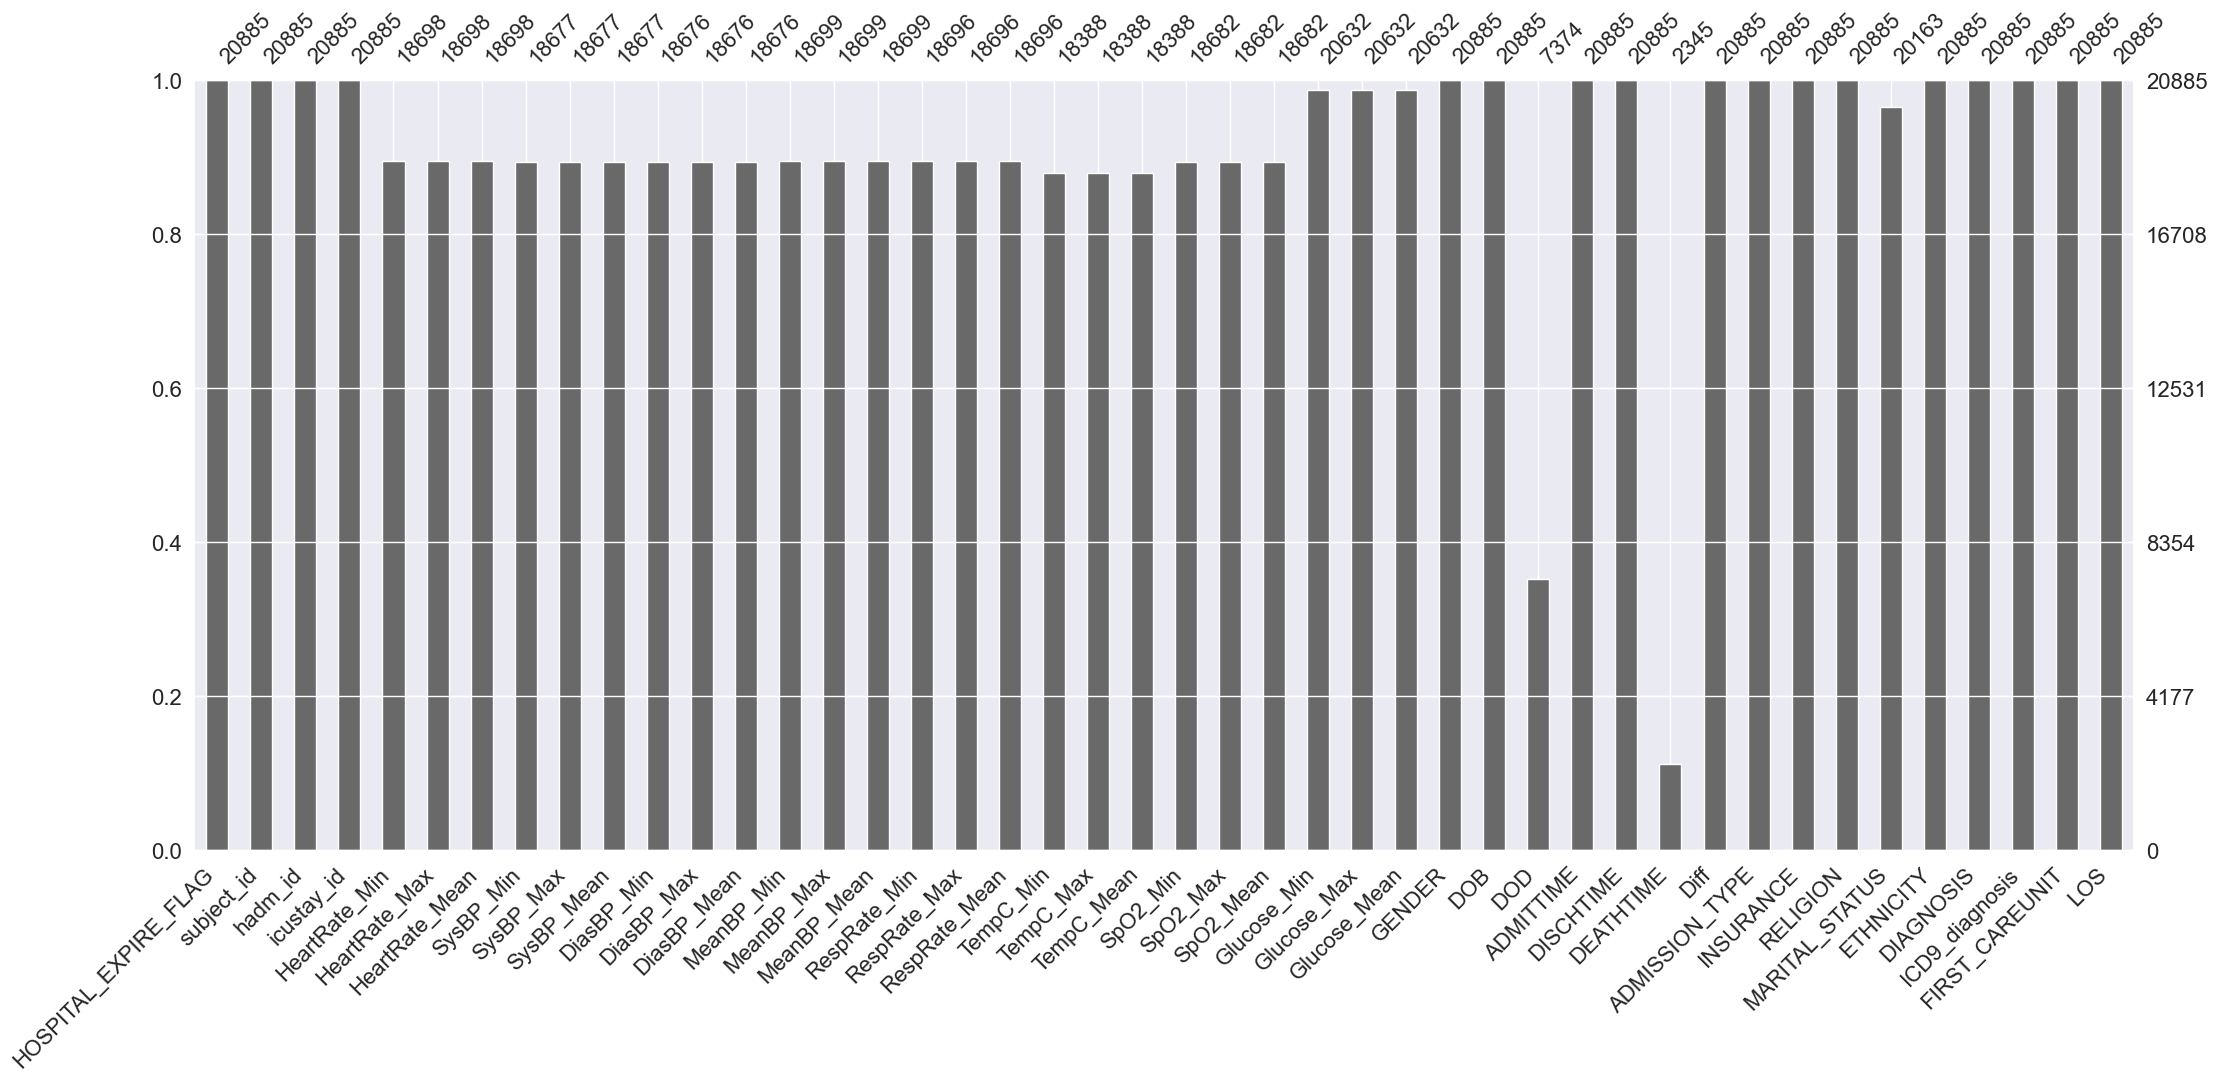

In [207]:
# Plotting the amount of missing data from our train data tells us much. 
msno.bar(df)

<AxesSubplot: >

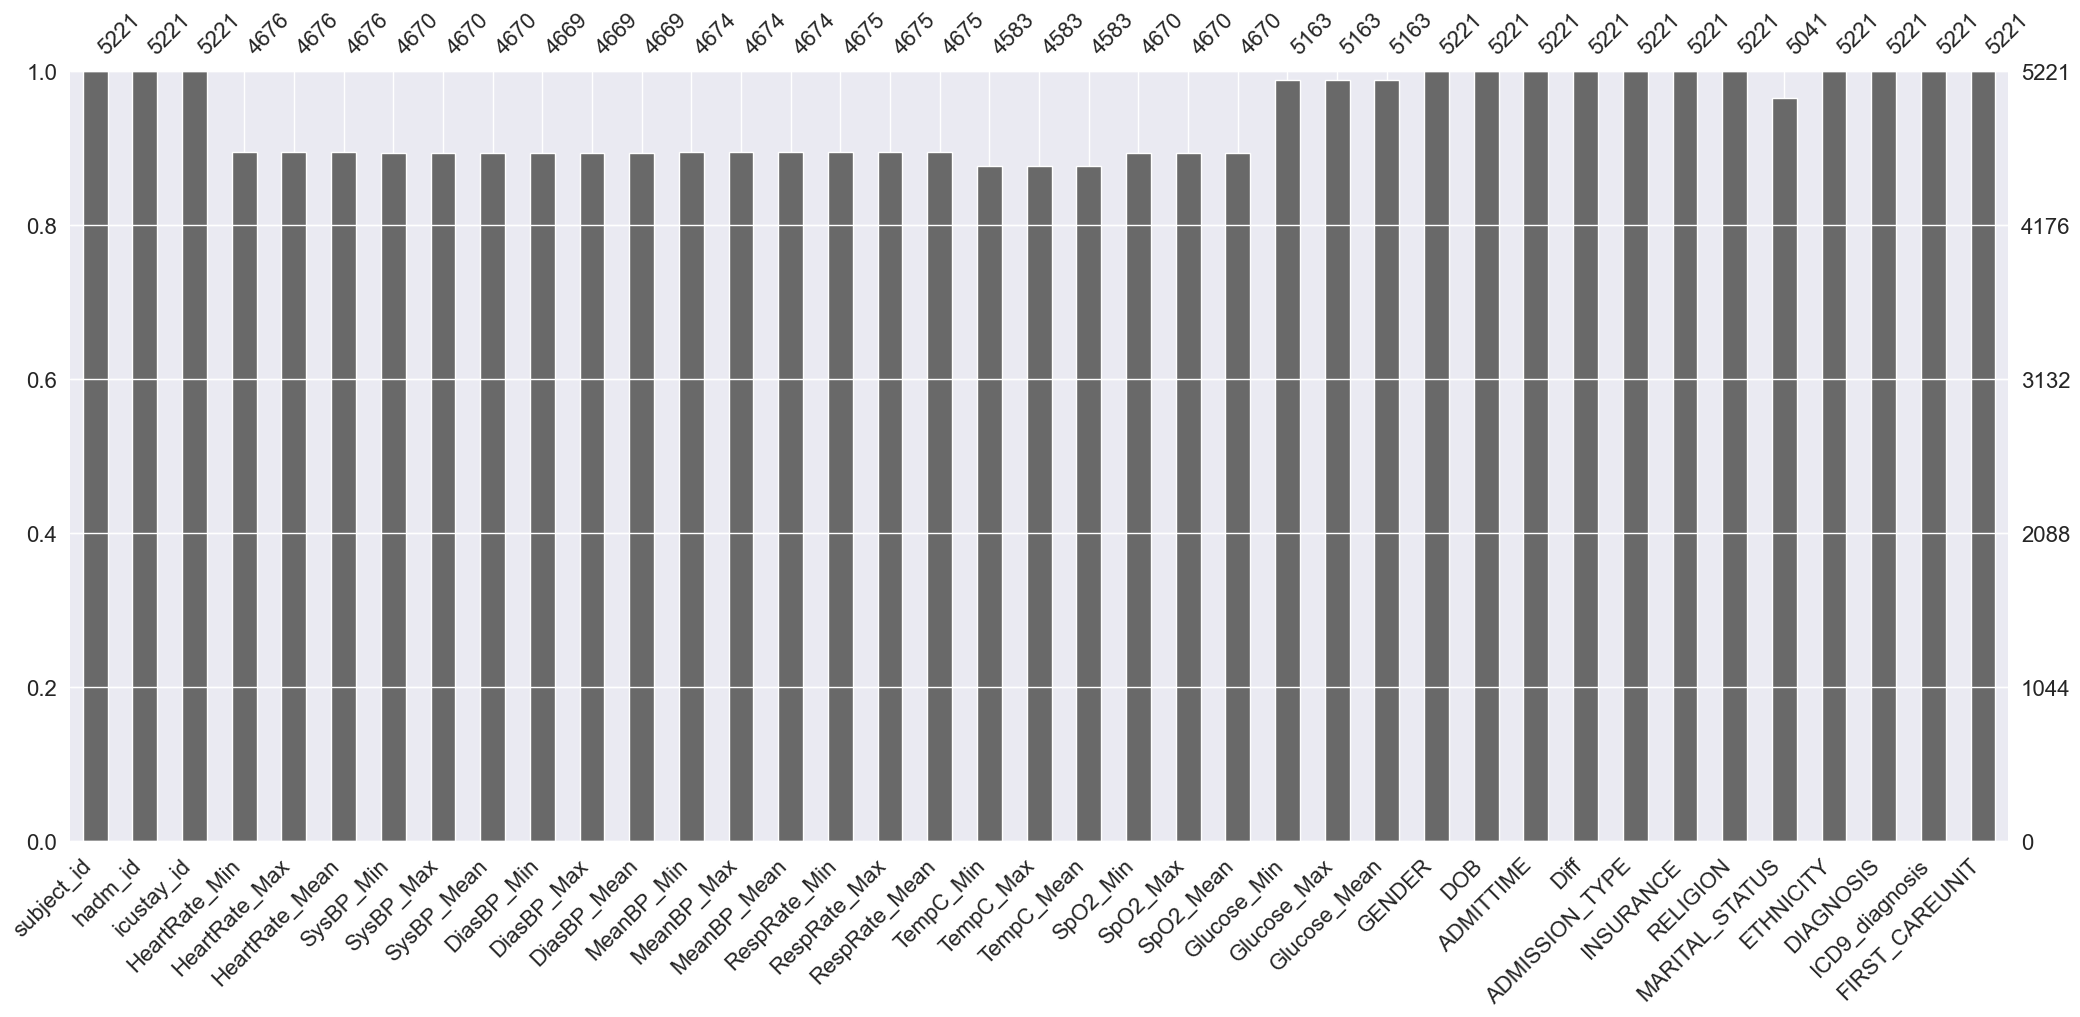

In [208]:
# We can see that our test data has also missing values. 
msno.bar(df_test)

In [209]:
# The column "DOD" is date of death, and we will not be needing it,  
# same goes for 'LOS', 'DISCHTIME','DEATHTIME','DIAGNOSIS'. WE will have to drop them sometime in the future
# df.DOD.head()
not_needed = df[['DOD', 'LOS', 'DISCHTIME', 'DEATHTIME', 'DIAGNOSIS']]
not_needed.head(3)

,DOD,LOS,DISCHTIME,DEATHTIME,DIAGNOSIS
0,2180-03-09 00:00:00,4.5761,2178-02-13 18:30:00,NaN,GASTROINTESTINAL BLEED
1,NaN,0.7582,2129-02-13 16:20:00,NaN,ESOPHAGEAL FOOD IMPACTION
2,NaN,3.7626,2125-12-05 17:55:00,NaN,UPPER GI BLEED


In [210]:
# Save numerical features as list
cols_list = df.columns.to_list()
cols_list_str =  ['GENDER', 'DOB', 'DOD', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME', 'ADMISSION_TYPE', 
                  'INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis', 
                  'FIRST_CAREUNIT']
cols_list_nostr = [var for var in cols_list if var not in cols_list_str]

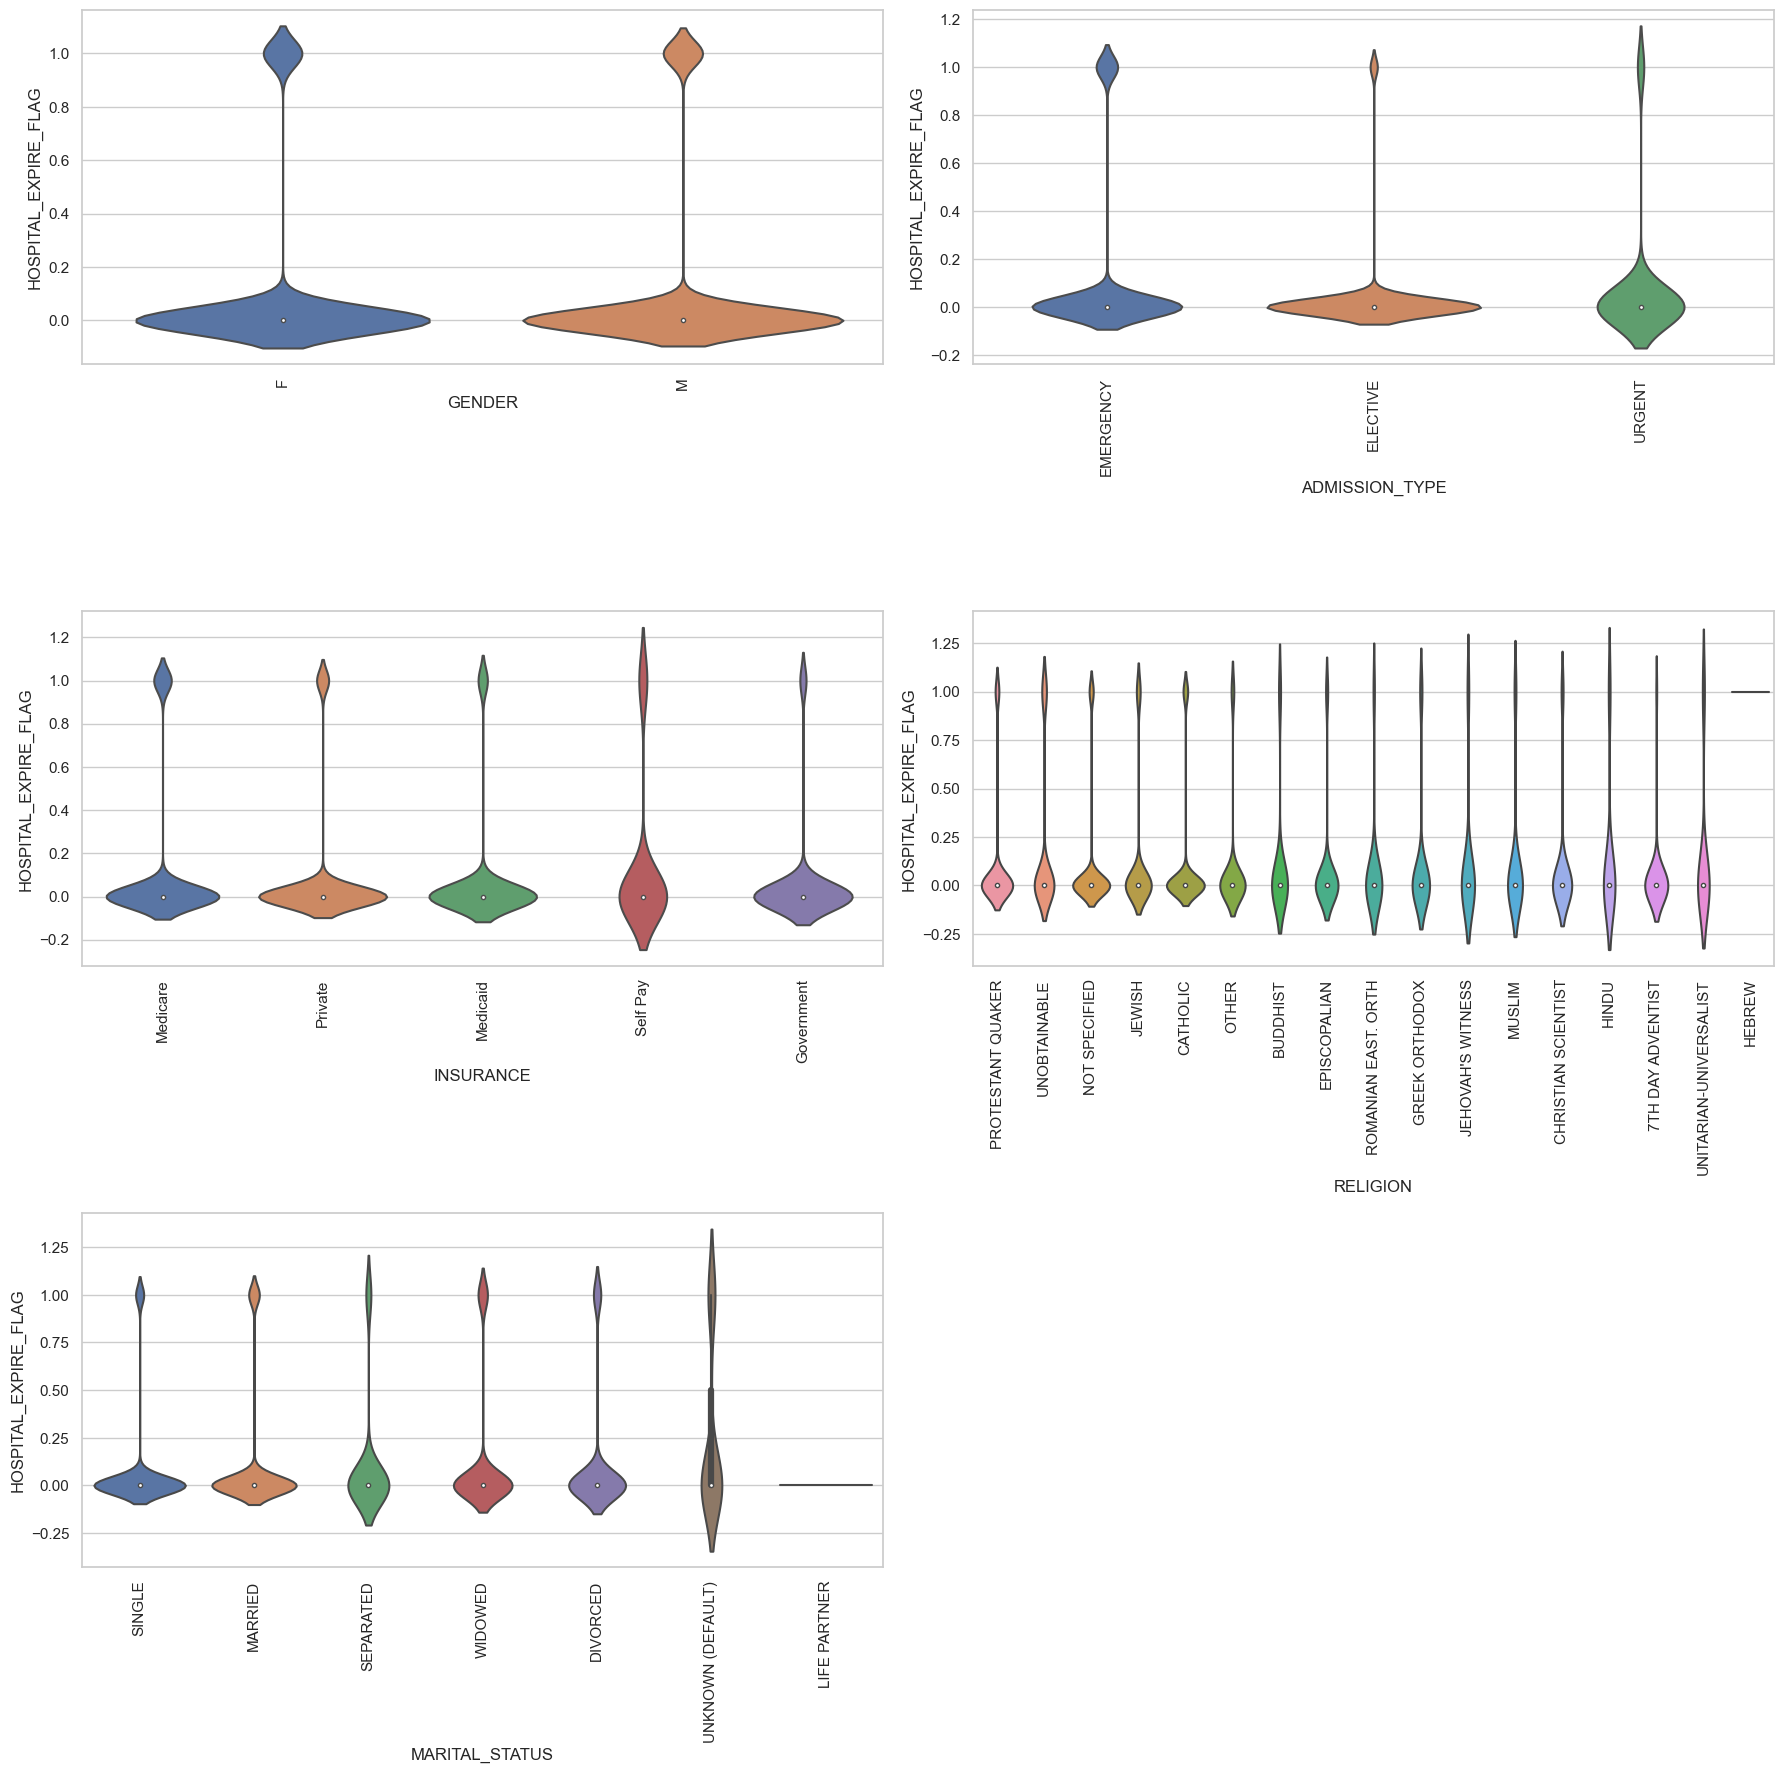

In [211]:

# Univariate violin plot distributions for categorical features
sns.set(style="whitegrid")
plt.figure(figsize=(18, 40)) # Size of the matrix plots
lst = [0, 6, 7, 8, 9]

k = 1
for i in lst:
  plt.subplot(7, 2, k) # row, cols and i is the element to plot
  sns.violinplot(x = cols_list_str[i], y = 'HOSPITAL_EXPIRE_FLAG', data = df )
  plt.xticks(rotation=90)
  k += 1

plt.tight_layout()

In [212]:
# Here we can see the proportion of females that survived in respect to males. 
# We could do the same for other categorical features but the graph above says it all. 
#fem_prop = df[np.where((df['GENDER'] == 'F') | (df['HOSPITAL_EXPIRE_FLAG'] == 1))].size

# 3. Feature engineering

### Dates

a. We need to have a look at the date-type columns of both the training and test datasets and try to come up with usable features like date of birth of each patient, time of dmission and e.t.c. 
Firstly, we  have to add the Diff column to the Date of Birth and ADMITTIME column, then we can calculate date of birth of each patient by substrating the DOB from the ADMITTIME.

In [213]:
# We need to change the columns in question into datetime variables. 
df['Diff']=df.apply(lambda x: timedelta(days=-x.Diff),axis=1)
df['DOB'] = df.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
df['DOB'] = df.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
df['ADMITTIME'] = df.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
df['ADMITTIME'] = df.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
df['age']=df.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

In [214]:
# Having changed the columns in the train dataset we will have to do the same in the test. 
df_test['Diff']=df_test.apply(lambda x: timedelta(days=-x.Diff),axis=1)
df_test['DOB'] = df_test.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
df_test['DOB'] = df_test.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
df_test['ADMITTIME'] = df_test.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
df_test['ADMITTIME'] = df_test.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
df_test['age']=df_test.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)

In [215]:
# Just checking our test data to ensure everything was done right. 
# the age column looks a bit weird, big numbers, we will have to work on it later (make it more relatable).
df_test[['DOB', 'ADMITTIME', 'age']].head(3)

,DOB,ADMITTIME,age
0,1929-11-30 13:44:32.640,2011-06-19 01:29:32.640,29785
1,1961-10-10 21:56:56.256,2010-02-27 21:54:56.256,17671
2,1967-04-27 09:11:19.104,2009-07-02 16:26:19.104,15407


b. WE can go ahead to extract the exact time, month, year each patient was admitted or if the patient was admited at night. 

In [216]:
# Computing year, month and hour of entry, along with admission time at night.

df['month'] = df['ADMITTIME'].apply(lambda x: x.month)
df['year'] = df['ADMITTIME'].apply(lambda x: x.year)
df['hour'] = df['ADMITTIME'].apply(lambda x: x.hour)
df_test['month'] = df_test['ADMITTIME'].apply(lambda x: x.month)
df_test['year'] = df_test['ADMITTIME'].apply(lambda x: x.year)
df_test['hour'] = df_test['ADMITTIME'].apply(lambda x: x.hour)

# here we could use different time as notation for night. e.g (10pm - 7am) or (10pm - 6am)
# if the hour of admission was later than 10 and earlier than 6 we give it 1 else 0. 
df['night_entrance']=np.where((df['hour'] > 22) | (df['hour'] < 6) , 1, 0)
df_test['night_entrance']=np.where((df_test['hour'] > 22) | (df_test['hour'] < 6) , 1, 0)

# The new columsn created after computing. 
date_related_cols=['year','month','hour','night_entrance']

c. Here we will drop the columns we have just used to get our new columns as we wont be needing them anymore. 

In [217]:
#Looking at the table we see that we won't be needing some columns therefore we get rid of them.

df = df.drop(['DOD','DOB','LOS','DISCHTIME','ADMITTIME','DEATHTIME','DIAGNOSIS', 'Diff'], axis=1)
#We do the same for the test data
df_test = df_test.drop(['DIAGNOSIS', 'DOB','ADMITTIME','Diff'], axis=1)

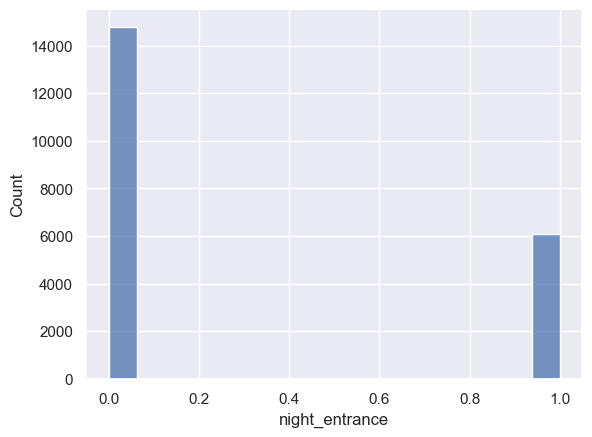

In [218]:
# Here we see the proportion of patients addmited at night time in respect to day time. 
# Exploring further we can that 1/3 of the patients were admitted at night time.

sns.set(style="darkgrid")
sns.histplot(data = df['night_entrance'], x = df['night_entrance'])
plt.show()

# Numerical and categorical data

a. Getting useful numerical data from categorical and date-related data

I tried getting a dummy variable for each column but it rather increased the run-time for the grid search, created a total of 132 columns (due to the high dimensionality of our data) and so I have decided to compute the mean associated to the HOSPITAL EXPIRE FLAG value for each categorical variable. Therefore, we will have a table with each categorical value (indexes) and their death rate (values). Hence, we just need to go over the training and the test set and, whenever we find the index, we change it for their corresponding death rate. We will do this for these columns:
- GENDER = 2
- ADMISSION TYPE = 3
- INSURANCE = 5
- RELIGION = 17
- MARITAL STATUS
- ETHNICITY = 41
- FIRST CAREUNIT = 5
The numbers on the right are the unique values in each column. If we create dummies for each column that would be a lot of dummies.

In [219]:
# to check the amount of unique values each column has.  
df['ADMISSION_TYPE'].unique().size

3

In [220]:
# Function to compute the death rate of a variable and add a new column to both training and test sets

def death_rate_sol(column,target):
  col_mean = df.groupby(column).mean()[target]
  df[column] = df[column].replace(to_replace = col_mean.index,value = col_mean.values)
  df_test[column] = df_test[column].replace(to_replace = col_mean.index,value = col_mean.values)

In [221]:
# Applying death rate function to the categoricals

cat_col = [name for name in df_test.select_dtypes(exclude = np.number).columns]
cat_col.remove('ICD9_diagnosis')
for col in cat_col:
  death_rate_sol(col,'HOSPITAL_EXPIRE_FLAG')

C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\187741890.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  col_mean = df.groupby(column).mean()[target]
C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\187741890.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  col_mean = df.groupby(column).mean()[target]
C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\187741890.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the functio

b. Fixing the age column we created. 

In [222]:
df['age'].head(3)

0    25407
1    15367
2    24897
Name: age, dtype: int64

We can create a new categorical variable (an age range) so we could easily group each patient to an age range.
Under 30 years, between 30 and 60 years, over 60 years.

In [223]:
df_test['age_inf'] = np.where(df_test['age'] < 11000, 'under_30', '30_to_60')
df_test['age_inf'] = np.where(df_test['age'] >= 22000, 'over_60', df_test['age_inf'])
df['age_inf'] = np.where(df['age'] < 11000, 'under_30', '30_to_60')
df['age_inf'] = np.where(df['age'] >= 22000, 'over_60', df['age_inf'])

death_rate_sol('age_inf','HOSPITAL_EXPIRE_FLAG')

C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\187741890.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  col_mean = df.groupby(column).mean()[target]


We will do the same for other date related columns we created earlier. 
e.g Hour of entrance, month of entrance, year of entrance, entrance at night

In [224]:
date_related_cols

['year', 'month', 'hour', 'night_entrance']

In [225]:
# We apply the death rate function. 

for col in date_related_cols:
  death_rate_sol(col,'HOSPITAL_EXPIRE_FLAG') #+'_death_rate'

C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\187741890.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  col_mean = df.groupby(column).mean()[target]
C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\187741890.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  col_mean = df.groupby(column).mean()[target]
C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\187741890.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the functio

c. Adding the extra data


The intuition behind bringing in this extra data is to merge our training data with the extra data by the HADM ID columns, so that we can associate all the extra ICD9 codes to the HOSPITAL EXPIRE FLAG of each patient. After that, we do the same we did to the categorical features above: change each ICD9 code with its associated death rate. 

In [226]:
# We merge and compute death rate for the diagnosis

alldata = pd.merge(df,ad,how = 'left',left_on = 'hadm_id',right_on = 'HADM_ID')

In [227]:
diag_mean = alldata.groupby('ICD9_CODE').mean()['HOSPITAL_EXPIRE_FLAG']
#mean
df['ICD9_diagnosis'] = df['ICD9_diagnosis'].replace(to_replace = diag_mean.index,value = diag_mean.values) 
#mean
df_test['ICD9_diagnosis'] = df_test['ICD9_diagnosis'].replace(to_replace = diag_mean.index,value = diag_mean.values)
#mean
df_test['ICD9_diagnosis'] = pd.to_numeric(df_test['ICD9_diagnosis'])

C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\2104007032.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diag_mean = alldata.groupby('ICD9_CODE').mean()['HOSPITAL_EXPIRE_FLAG']


In [228]:
#mean
alldata['ICD9_CODE'] = alldata['ICD9_CODE'].replace(to_replace = diag_mean.index,value = diag_mean.values)

After we have changed the ICD9 code for their associated death rate, we will repeat the procedure and now compute the following: for each HADM ID, we will compute the death rate corresponding to the mean of means of all the diagnosis that patient had in that hospital stay. We can also compute the maximum death rate (i.e the diagnose that had the highest death rate). We will add these two columns:

- mean of means
- max of means
to both training and test set. In the test set, for those HADM ID which did not appear in the training set, we will add a Non-Numerical Value (NaN), since we do not have the correct information. Hence, with the upcoming preprocessing that we will see, these NaN will be correctly dealt with.

In [229]:
# Mean() and max() of the death rates for each diagnosis that a patient has in each stay

mean_of_means = alldata.groupby('HADM_ID').mean()['ICD9_CODE']
max_of_all = alldata.groupby('HADM_ID').max()
max_of_means = max_of_all['ICD9_CODE']

C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\3079511675.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_of_means = alldata.groupby('HADM_ID').mean()['ICD9_CODE']


In [230]:
# Computing mean of means
df['mean_of_means'] = df['hadm_id'].replace(to_replace = mean_of_means.index,value = mean_of_means.values)
df_test['mean_of_means'] = df_test['hadm_id'].replace(to_replace = mean_of_means.index,value = mean_of_means.values)
df_test['mean_of_means'] = np.where(df_test['mean_of_means'] > 1, np.nan, df_test['mean_of_means'])

In [231]:
# Computing max of means
df['max_of_means'] = df['hadm_id'].replace(to_replace = max_of_means.index,value = max_of_means.values)
df_test['max_of_means'] = df_test['hadm_id'].replace(to_replace = max_of_means.index,value = max_of_means.values)
df_test['max_of_means'] = np.where(df_test['max_of_means'] > 1, np.nan, df_test['max_of_means'])

We can also compute the number of comoborbidities a patient had for each HADM ID. i.e how many patients had more than one illness at a time. 

In [232]:
## Number of comorbidites in each hospital stay

num_of_comob = ad['HADM_ID'].value_counts()
df['num_of_comob'] = df['hadm_id'].replace(to_replace = num_of_comob.index,value = num_of_comob.values)
df_test['num_of_comob'] = df_test['hadm_id'].replace(to_replace = num_of_comob.index,value = num_of_comob.values)

d. Training sets and checking class imbalance

In [233]:
X_train = df.drop(['HOSPITAL_EXPIRE_FLAG'], axis=1) 
y_train = df["HOSPITAL_EXPIRE_FLAG"] 

Text(0, 0.5, 'counts')

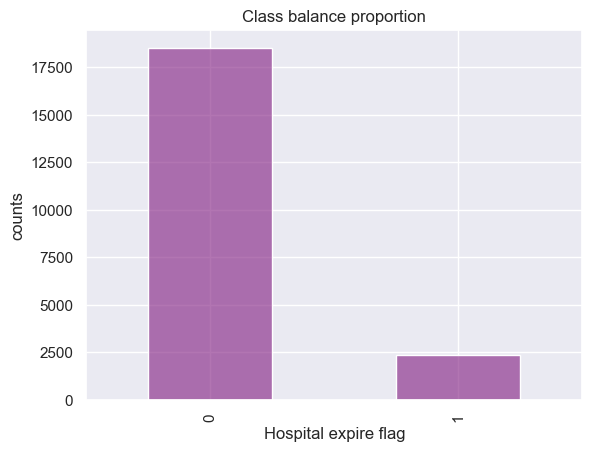

In [234]:
# We can visualise this class imbalance problem we are facing. 

y_train.value_counts().plot(kind="bar", color = (0.5,0.1,0.5,0.6))
plt.title('Class balance proportion')
plt.xlabel('Hospital expire flag')
plt.ylabel('counts')

We have a problem of class imbalance
There are several ways to go about it. 
1.	Under sampling majority class:
Here we could take randomly picked 2500 data from the people who do NOT die and add them to the 2500 data of the minority that is people who die and discard the remaining data. Through this method we loose so much viable data. 
2.	Over sampling the minority class:
Duplicating the minority 2500 data to get up to the 17500 and train the model. 
3.	Over sampling with SMOTE(Synthetic Minority over-sampling technique):
Using K-nearest neighbor to produce synthetic samples. 

We will make decision on that as we go. 

# 4. Preprocessing data

We will put all the methods together with the Pipeline module.

Since we do not have categorical features anymore, we just have to create a Pipeline for the numerical data.

We will first impute all the NaN with the IterativeImputer. This imputer changes the NaN's with the mean of the corresponding column. However, it goes through all the features in the data in order to just use the correct observations for each NaN. Therefore, it improves the performance of the SimpleImputer, which just computes the column mean without taking into account all other features.

Then, we will use the Standard Scaler in order to scale the data, just like you taught us in class. We will use the StandardScaler. 

In [235]:
# We define the Pipelines for both types of features

numeric_transformer = Pipeline(steps=[
       ('imputer', IterativeImputer())
      ,('scaler', StandardScaler())
      
])

In [236]:
# We will put the numerical Pipeline into a ColumnTransformer, which applies the different methods in 
#the Pipeline to all columns.
# Define lists with the numerical and categorical values separately

num_feat=[name for name in df_test.select_dtypes(include = np.number).columns]
cat_feat=[name for name in df_test.select_dtypes(exclude = np.number).columns]

# We define the preprocessor

preprocessor = ColumnTransformer(
   transformers = [
    ('numeric', numeric_transformer, num_feat)
]) 

## Define the pipeline with the preprocessor

pipeline = Pipeline(steps = [('preprocessor', preprocessor)])

In [237]:
# at this point we should have an empty categorical variables. 

cat_feat

[]

# 5. KNN model

<strong>Defining the model </strong><br>
We begin by defining our KNN model with the KNeighborsClassifier function. We will run this model with the brute algorithm, instead of using the KD Tree or Ball Tree algorithms because we are working with high-dimensional data. KD Tree works better with medium-dimensional data and we cannot use the Ball Tree algorithm, even though it can be used with high-dimensional data because it is highly depends on data having a structure that allows building the minimum hyperspheres. For noisy and/or high-dimensional data, it may need a higher number of balls, and therefore provides little gains from the brute algorithm.
Then, we define the parameters that we are going to go through in the GridSearch in order to find the best value of each one of them:

<strong>Number of nearest neighbors:</strong><br> list of integer numbers that will determine how many neighbors should the model check everytime. A way to know an approximate range of optimality for the value of K is to do the square root of the number of observations. Therefore, depending on the method we use to deal with class imbalance, we will use a higher or lower value of K, as we will later see.<br>
<strong>Metric:</strong><br> since we are working with the brute algorithm, we can get its valid metrics and check them all.<br>
<strong>Weights:</strong><br> we will try to run the default uniform feature and the one that weights all the measures it does.
Furthermore, we will work with the basic score for the Area Under the Curve (roc auc) and also with a weighted version of it (roc auc ovr weighted), in order to also take into account the weights of the results.

In [240]:
# Defining the KNeighborsClassifier()

MyKNN = KNeighborsClassifier()

In [241]:
# Metrics for the brute algorithm

metrics=sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute'])
metrics.remove('precomputed')

# Scoring of the GridSearch
scoring = {"auc_ovr": "roc_auc_ovr_weighted", "auc": 'roc_auc'}

<strong>Class imbaance issue</strong><br>
Both methods are quite good but also have their flaws. 
while over-sampling does not lose information and therefore performs a better training of the model, it can bring problems of over-fitting, since it has too many new samples.<br>
On the other hand, undersampling does not overfit the model, but in exchange of losing too many information and therefore, a worse training performance.<br>
I recon we try both methods and see their different results.<br>
We will use <i>RandomUnderSampler</i> for under-sampling and <i>SMOTE</i> for over-sampling. 

In [242]:
undersampler=RandomUnderSampler()
oversampler=SMOTE()

a. Fitting the model and checking performance

In [243]:
# We fit the pipeline we created before with our X_train, in order to do all the 
# preprocessing to it. We use fit transform and we assign it to a new variable X_p.

X_p = pipeline.fit_transform(X_train)

b. Over-sampling

To compute the optimal number of nearest neighbors for each of our methods:<br>
(We could calculate it roughly by squaring the our observations)

With under-sampling, we get 4690 observations (rows) and thus, the optimal K would be around (68) approximately 70.<br>
With over-sampling, there are 37080 observations. Hence, the optimal K would be around (192) approximately 190.

In [244]:
# X_p_o and y_train_o - over-sampled data 

X_p_o, y_train_o = oversampler.fit_resample(X_p, y_train)

(37080, 44)


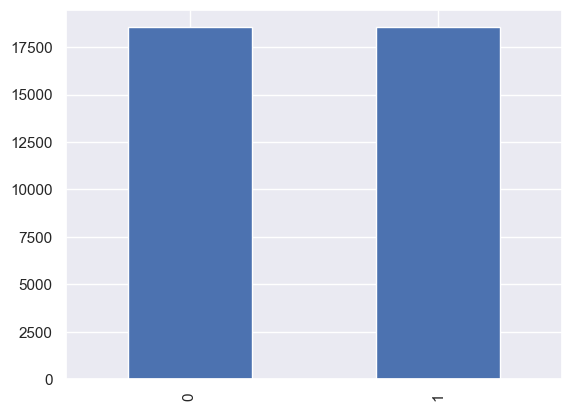

In [245]:
y_train_o.value_counts().plot(kind="bar")
print(X_p_o.shape)

We define our over-sampled data, with the optimal value for the number of nearest neighbors we roughly calculated above.

In [246]:
# Number of nearest neighbors used for over-sampling
over_n=[160,170,180,190,200]

# GridSearch parameters for over-sampling
grid_values_o = {'algorithm':['brute'],
               'n_neighbors':over_n,'weights':['uniform','distance']
               , 'metric':metrics}

We define our <i>GridSearch</i> and print the best parameters that it finds.

In [247]:
## GridSearch defined, fitted and its best parameters printed

grid_knn_acc_o = GridSearchCV(MyKNN, param_grid = grid_values_o,scoring = scoring, refit='auc',cv=10, verbose=3)
grid_knn_acc_o.fit(X_p_o,y_train_o)
print('Best algorithm : '+ str(grid_knn_acc_o.best_estimator_.algorithm))
print('Best k parameter : '+ str(grid_knn_acc_o.best_estimator_.n_neighbors))
print('Best weights parameter : '+ str(grid_knn_acc_o.best_estimator_.weights))
print('Best k parameter : '+ str(grid_knn_acc_o.best_estimator_.metric))
print("Best parameter (CV score=%0.3f):" % grid_knn_acc_o.best_score_)

Fitting 10 folds for each of 60 candidates, totalling 600 fits
[CV 1/10] END algorithm=brute, metric=cityblock, n_neighbors=160, weights=uniform; auc: (test=0.945) auc_ovr: (test=0.945) total time=   2.1s
[CV 2/10] END algorithm=brute, metric=cityblock, n_neighbors=160, weights=uniform; auc: (test=0.961) auc_ovr: (test=0.961) total time=   2.0s
[CV 3/10] END algorithm=brute, metric=cityblock, n_neighbors=160, weights=uniform; auc: (test=0.967) auc_ovr: (test=0.967) total time=   2.0s
[CV 4/10] END algorithm=brute, metric=cityblock, n_neighbors=160, weights=uniform; auc: (test=0.964) auc_ovr: (test=0.964) total time=   1.9s
[CV 5/10] END algorithm=brute, metric=cityblock, n_neighbors=160, weights=uniform; auc: (test=0.961) auc_ovr: (test=0.961) total time=   2.1s
[CV 6/10] END algorithm=brute, metric=cityblock, n_neighbors=160, weights=uniform; auc: (test=0.968) auc_ovr: (test=0.968) total time=   2.1s
[CV 7/10] END algorithm=brute, metric=cityblock, n_neighbors=160, weights=uniform; au

Predictions with the obtained optimal value on the over-sampling dataset.

In [248]:

insample_y_pred_o = grid_knn_acc_o.predict(X_p_o)

## Accuracy of those predictions

print('Accuracy Score : ' + str(accuracy_score(y_train_o,insample_y_pred_o)))
print('Precision Score : ' + str(precision_score(y_train_o,insample_y_pred_o)))
print('Recall Score : ' + str(recall_score(y_train_o,insample_y_pred_o)))
print('F1 Score : ' + str(f1_score(y_train_o,insample_y_pred_o)))

Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0


AUC:  0.984414211553433


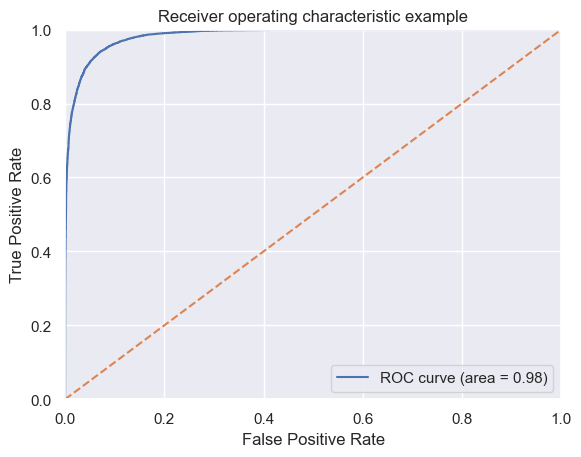

In [256]:
# We apply cross-validation to get probabilities on the training set and plot the AUC.

MyKNN_optimal_o = KNeighborsClassifier(n_neighbors = 160,algorithm = 'brute',metric = 'cosine',weights = 'distance')
                                     
y_probs_KNN_o = cross_val_predict(MyKNN_optimal_o, X_p_o, y_train_o,
                            method='predict_proba',cv = 5)

get_auc(y=y_train_o, y_pred_probabilities=y_probs_KNN_o, class_labels=['Alive','Dead'], column = 1, plot = True) # Help function

c. Under-sampling

We do the same as we did for over-sampling data. 
- resampling the training data<br>
- check if they are balanced<br>
- check if we have the right observation and features.

In [250]:
X_p_u, y_train_u = undersampler.fit_resample(X_p, y_train)

(4690, 44)


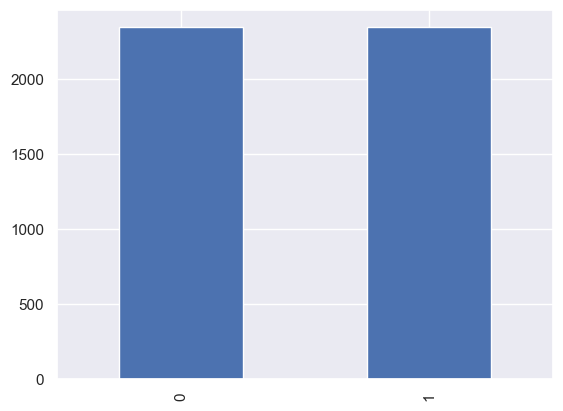

In [252]:
y_train_u.value_counts().plot(kind = "bar")
print(X_p_u.shape)

In [253]:
# Number of nearest neighbors used for under-sampling (calculated for approx. 70, but we will give range just incase)
under_n=list(range(50,80))

## GridSearch parameters for under-sampling
grid_values_u = {'algorithm':['brute'],
               'n_neighbors':under_n,'weights':['uniform','distance']
               , 'metric':metrics}

In [254]:
# We define the GridSearch, fit it and also print its best parameters.

grid_knn_acc_u = GridSearchCV(MyKNN, param_grid = grid_values_u,scoring = scoring, refit = 'auc',cv = 10, verbose = 3)
grid_knn_acc_u.fit(X_p_u,y_train_u)
print('Best algorithm : '+ str(grid_knn_acc_u.best_estimator_.algorithm))
print('Best k parameter : '+ str(grid_knn_acc_u.best_estimator_.n_neighbors))
print('Best weights parameter : '+ str(grid_knn_acc_u.best_estimator_.weights))
print('Best k parameter : '+ str(grid_knn_acc_u.best_estimator_.metric))
print("Best parameter (CV score=%0.3f):" % grid_knn_acc_u.best_score_)

Fitting 10 folds for each of 360 candidates, totalling 3600 fits
[CV 1/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.931) auc_ovr: (test=0.931) total time=   0.0s
[CV 2/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.940) auc_ovr: (test=0.940) total time=   0.0s
[CV 3/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.934) auc_ovr: (test=0.934) total time=   0.0s
[CV 4/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.945) auc_ovr: (test=0.945) total time=   0.0s
[CV 5/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.945) auc_ovr: (test=0.945) total time=   0.0s
[CV 6/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (test=0.929) auc_ovr: (test=0.929) total time=   0.0s
[CV 7/10] END algorithm=brute, metric=cityblock, n_neighbors=50, weights=uniform; auc: (t

In [255]:
# Predictions from the training set

insample_y_pred_u = grid_knn_acc_u.predict(X_p_u)

## Accuracy of those predictions
print('Accuracy Score : ' + str(accuracy_score(y_train_u,insample_y_pred_u)))
print('Precision Score : ' + str(precision_score(y_train_u,insample_y_pred_u)))
print('Recall Score : ' + str(recall_score(y_train_u,insample_y_pred_u)))
print('F1 Score : ' + str(f1_score(y_train_u,insample_y_pred_u)))

Accuracy Score : 1.0
Precision Score : 1.0
Recall Score : 1.0
F1 Score : 1.0


AUC:  0.9406376584940058


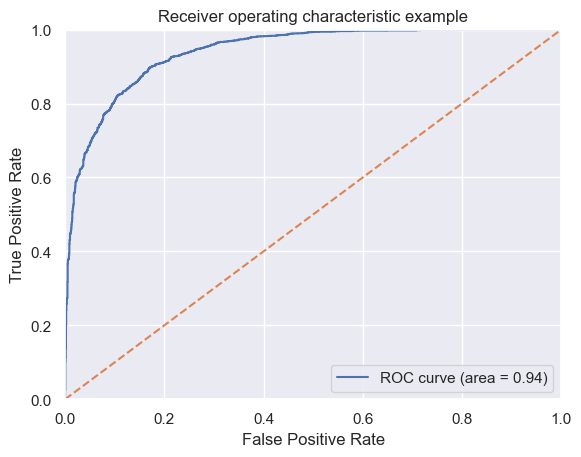

In [257]:
# We apply cross-validation to get probabilities on the training set and plot the AUC.
# Note nearest neighbors has to always be odd numbers, lucky enough ours is 57.  

MyKNN_optimal_u = KNeighborsClassifier(n_neighbors = 57,algorithm = 'brute',metric = 'cityblock',weights = 'distance')
                                     
y_probs_KNN_u = cross_val_predict(MyKNN_optimal_u, X_p_u, y_train_u,
                            method = 'predict_proba',cv = 5)

get_auc(y=y_train_u, y_pred_probabilities = y_probs_KNN_u, class_labels = ['Alive','Dead'], column = 1, plot = True) 

# 6. Predictions with the K-NN model

- Apply the preprocessing to the test set, <br>
- define a reweight function, so that the predictions that we will later produce take into account the balancing of our classes.

In [258]:
test_p = pipeline.transform(df_test)

In [259]:
q1 = y_train.sum()/len(y_train)
def reweight(pi,q1,r1):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

a. Predictions from over-sampling

In [260]:
# Get the predictions of the test set
y_pred_o = grid_knn_acc_o.predict_proba(test_p)

In [261]:
## the correction factor: 
r1_o = y_train_o.sum()/len(y_train_o)

we create the file with the icustay id, the predicted probabilities of death and apply the reweighting function to the obtained results.

In [262]:

test_kaggle_o = df_test[['icustay_id']] ## The unique ID
test_kaggle_o["HOSPITAL_EXPIRE_FLAG"] = y_pred_o[:,1]

# Apply reweight
test_kaggle_o["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_o["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args = (q1,r1_o))

test_kaggle_o.head()

C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\3985169696.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_o["HOSPITAL_EXPIRE_FLAG"] = y_pred_o[:,1]
C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\3985169696.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_o["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_o["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args = (q1,r1_o))


,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.002387
1,251754,0.069169
2,242171,0.054159
3,263035,0.659889
4,279388,0.208477


In [263]:
# Create the csv with our results

test_kaggle_o.to_csv("KNN_pred_oversampling_7.csv", index = False)

b. Predictions from under-sampling

In [264]:
# Get the predictions of the test set
y_pred_u = grid_knn_acc_u.predict_proba(test_p)

In [265]:
# the correction factor: 
r1_u = y_train_u.sum()/len(y_train_u)

In [266]:

test_kaggle_u = df_test[['icustay_id']] ## The unique ID
test_kaggle_u["HOSPITAL_EXPIRE_FLAG"] = y_pred_u[:,1]

# Apply reweight
test_kaggle_u["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_u["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args = (q1,r1_u))
test_kaggle_u.head()

C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\2368023069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_u["HOSPITAL_EXPIRE_FLAG"] = y_pred_u[:,1]
C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\2368023069.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_u["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_u["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args = (q1,r1_u))


,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.006838
1,251754,0.045542
2,242171,0.017095
3,263035,0.166329
4,279388,0.047321


In [267]:
# Create the csv with our results

test_kaggle_u.to_csv("KNN_pred_undersampling_7.csv", index = False)

# 7. SVM

### Defining the model

We begin by defining our SVM model with the SVC function. We will run this model enabling the probability estimates.

Then, we define the parameters that we are going to go through in the GridSearch in order to find the best value of each one of them:

- Cost parameter: list of integer numbers that will as a regularization parameter to prevent overfitting.
- Kernel: the Kernel inner product function. We will try the four options that sklearn provides: linear, poly, rbf and sigmoid.
- Gamma: we try several values of the Kernel coefficient for poly, rbf and sigmoid.
Furthermore, we will work with the basic score for the Area Under the Curve (roc auc) and also with a weighted version of it (roc auc ovr weighted), in order to also take into account the weights of the results.

In [268]:
# We assign to a variable the 'SVC' function

MySVC = SVC(probability=True)

In [269]:
# We set our parameters for GridSearch
grid_values_SVM = {'C':[0.1, 1, 5, 10], 'kernel':['linear', 'poly', 'rbf', 'sigmoid'], 
                   'gamma':[0.03,0.1,0.25,0.5,0.75], }
scoring = {"auc_ovr": "roc_auc_ovr_weighted", "auc": 'roc_auc'}

SVM performs better with a smaller number of samples and besides it has a high computational time and so using our under-sampling dataset we can test for more parameter to obtain a good result. 

In [270]:
undersampler=RandomUnderSampler()

a. Fitting the model and checking performance

In [271]:
X_p = pipeline.fit_transform(X_train)

In [272]:
X_p_u, y_train_u = undersampler.fit_resample(X_p, y_train)

(4690, 44)


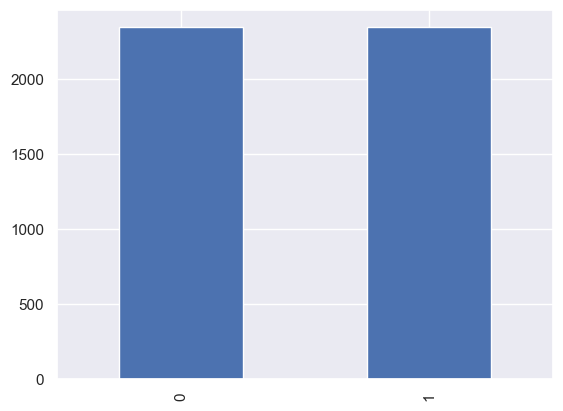

In [273]:
y_train_u.value_counts().plot(kind="bar")
print(X_p_u.shape)

In [274]:
# We define the GridSearch, fit it and also print its best parameters.

grid_knn_acc_SVC = GridSearchCV(MySVC, param_grid = grid_values_SVM, scoring = scoring, refit='auc',cv = 5, verbose = 3)
grid_knn_acc_SVC.fit(X_p_u,y_train_u)
print('Best cost parameter : '+ str(grid_knn_acc_SVC.best_estimator_.C))
print('Best kernel : '+ str(grid_knn_acc_SVC.best_estimator_.kernel))
print('Best gamma : '+ str(grid_knn_acc_SVC.best_estimator_.gamma))
print("Best parameter (CV score=%0.3f):" % grid_knn_acc_SVC.best_score_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
[CV 1/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.952) auc_ovr: (test=0.952) total time=   2.8s
[CV 2/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.950) auc_ovr: (test=0.950) total time=   2.7s
[CV 3/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.955) auc_ovr: (test=0.955) total time=   3.0s
[CV 4/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.948) auc_ovr: (test=0.948) total time=   2.7s
[CV 5/5] END C=0.1, gamma=0.03, kernel=linear; auc: (test=0.948) auc_ovr: (test=0.948) total time=   2.4s
[CV 1/5] END C=0.1, gamma=0.03, kernel=poly; auc: (test=0.947) auc_ovr: (test=0.947) total time=   4.0s
[CV 2/5] END C=0.1, gamma=0.03, kernel=poly; auc: (test=0.932) auc_ovr: (test=0.932) total time=   3.5s
[CV 3/5] END C=0.1, gamma=0.03, kernel=poly; auc: (test=0.941) auc_ovr: (test=0.941) total time=   3.7s
[CV 4/5] END C=0.1, gamma=0.03, kernel=poly; auc: (test=0.936) auc_ovr: (test=0.936) total time=

In [275]:
## Predictions from the training set
insample_y_pred_SVC = grid_knn_acc_SVC.predict(X_p_u)

## Accuracy of those predictions
print('Accuracy Score : ' + str(accuracy_score(y_train_u,insample_y_pred_SVC)))
print('Precision Score : ' + str(precision_score(y_train_u,insample_y_pred_SVC)))
print('Recall Score : ' + str(recall_score(y_train_u,insample_y_pred_SVC)))
print('F1 Score : ' + str(f1_score(y_train_u,insample_y_pred_SVC)))

Accuracy Score : 0.8842217484008529
Precision Score : 0.8729304635761589
Recall Score : 0.899360341151386
F1 Score : 0.8859483301827347


AUC:  0.9502351780542915


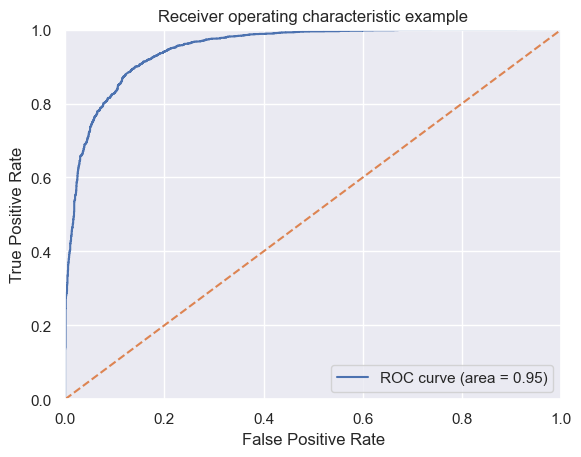

In [276]:
## Defining the SVM model with the optimal results,
## apply cross-validation to get probabilities on the training set
## and plot the AUC.

MySVC_optimal = SVC(C = 10, kernel='linear',gamma = 0.03, probability=True)

y_probs_SVC = cross_val_predict(MySVC_optimal, X_p_u, y_train_u,method = 'predict_proba',cv = 5)

get_auc(y = y_train_u, y_pred_probabilities=y_probs_SVC, class_labels=['Alive','Dead'], column = 1, plot = True) 

### Assessing predictions with the model

In [277]:
test_p = pipeline.transform(df_test)

In [278]:
q1 = y_train.sum()/len(y_train)
def reweight(pi,q1,r1):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

In [279]:
## Get the predictions of the test set
y_pred_SVC=grid_knn_acc_SVC.predict_proba(test_p)

In [280]:
## the correction factor: 
r1_u = y_train_u.sum()/len(y_train_u)

In [281]:
## Add our predictions to the result DataFrame we will use
## to create our csv of results

test_kaggle_SVM = df_test[['icustay_id']] ## The unique ID
test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"] = y_pred_SVC[:,1]

# Apply reweight
test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args = (q1,r1_u))
test_kaggle_SVM.head()

C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\2551302629.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"] = y_pred_SVC[:,1]
C:\Users\bakwe\AppData\Local\Temp\ipykernel_27044\2551302629.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"] = test_kaggle_SVM["HOSPITAL_EXPIRE_FLAG"].apply(reweight,args = (q1,r1_u))


,icustay_id,HOSPITAL_EXPIRE_FLAG
0,208169,0.008301
1,251754,0.034134
2,242171,0.002303
3,263035,0.200862
4,279388,0.011981


In [282]:
# Create the csv with our results

test_kaggle_SVM.to_csv("SVM_pred_7.csv", index = False)